In [1]:
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import RFormula
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import BinaryClassificationMetrics

spark = SparkSession.builder.master('local')\
.appName("Alex_603_proj")\
.getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/12 18:05:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df  = spark.read.option("header", "true").csv('host_train.csv')

In [3]:
df.printSchema()

root
 |-- case_id: string (nullable = true)
 |-- Hospital: string (nullable = true)
 |-- Hospital_type: string (nullable = true)
 |-- Hospital_city: string (nullable = true)
 |-- Hospital_region: string (nullable = true)
 |-- Available_Extra_Rooms_in_Hospital: string (nullable = true)
 |-- Department: string (nullable = true)
 |-- Ward_Type: string (nullable = true)
 |-- Ward_Facility: string (nullable = true)
 |-- Bed_Grade: string (nullable = true)
 |-- patientid: string (nullable = true)
 |-- City_Code_Patient: string (nullable = true)
 |-- Type of Admission: string (nullable = true)
 |-- Illness_Severity: string (nullable = true)
 |-- Patient_Visitors: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Admission_Deposit: string (nullable = true)
 |-- Stay_Days: string (nullable = true)



In [4]:
print(f"Counts of rows/samples: {df.count()}")
print(f"Counts of columns/features: {len(df.columns)}")

Counts of rows/samples: 318438
Counts of columns/features: 18


In [5]:
df.show(5)

+-------+--------+-------------+-------------+---------------+---------------------------------+------------+---------+-------------+---------+---------+-----------------+-----------------+----------------+----------------+-----+-----------------+---------+
|case_id|Hospital|Hospital_type|Hospital_city|Hospital_region|Available_Extra_Rooms_in_Hospital|  Department|Ward_Type|Ward_Facility|Bed_Grade|patientid|City_Code_Patient|Type of Admission|Illness_Severity|Patient_Visitors|  Age|Admission_Deposit|Stay_Days|
+-------+--------+-------------+-------------+---------------+---------------------------------+------------+---------+-------------+---------+---------+-----------------+-----------------+----------------+----------------+-----+-----------------+---------+
|      1|       8|            2|            3|              2|                                3|radiotherapy|        R|            F|      2.0|    31397|              7.0|        Emergency|         Extreme|               2|51-

In [6]:
df2 = df.withColumnRenamed("Type of Admission", "Type_of_Admission")\
      .withColumnRenamed("patientid", "Patient_id")


df3 = df2.toDF(*[c.lower() for c in df2.columns])
df3.printSchema()



root
 |-- case_id: string (nullable = true)
 |-- hospital: string (nullable = true)
 |-- hospital_type: string (nullable = true)
 |-- hospital_city: string (nullable = true)
 |-- hospital_region: string (nullable = true)
 |-- available_extra_rooms_in_hospital: string (nullable = true)
 |-- department: string (nullable = true)
 |-- ward_type: string (nullable = true)
 |-- ward_facility: string (nullable = true)
 |-- bed_grade: string (nullable = true)
 |-- patient_id: string (nullable = true)
 |-- city_code_patient: string (nullable = true)
 |-- type_of_admission: string (nullable = true)
 |-- illness_severity: string (nullable = true)
 |-- patient_visitors: string (nullable = true)
 |-- age: string (nullable = true)
 |-- admission_deposit: string (nullable = true)
 |-- stay_days: string (nullable = true)



In [7]:
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F

string_to_integer_list = ['hospital', 'hospital_type', 'hospital_city','hospital_region','available_extra_rooms_in_hospital',
                          'bed_grade','city_code_patient','patient_visitors','admission_deposit']
df4 = df3
for col in string_to_integer_list:
  df4 = df4.withColumn(col, F.col(col).astype(IntegerType()))

df4.printSchema()

root
 |-- case_id: string (nullable = true)
 |-- hospital: integer (nullable = true)
 |-- hospital_type: integer (nullable = true)
 |-- hospital_city: integer (nullable = true)
 |-- hospital_region: integer (nullable = true)
 |-- available_extra_rooms_in_hospital: integer (nullable = true)
 |-- department: string (nullable = true)
 |-- ward_type: string (nullable = true)
 |-- ward_facility: string (nullable = true)
 |-- bed_grade: integer (nullable = true)
 |-- patient_id: string (nullable = true)
 |-- city_code_patient: integer (nullable = true)
 |-- type_of_admission: string (nullable = true)
 |-- illness_severity: string (nullable = true)
 |-- patient_visitors: integer (nullable = true)
 |-- age: string (nullable = true)
 |-- admission_deposit: integer (nullable = true)
 |-- stay_days: string (nullable = true)



In [8]:
from pyspark.ml.feature import StringIndexer
import pyspark.sql.functions as F

string_to_integer_list = ['department','ward_facility', 'ward_type','illness_severity','type_of_admission']

def custom_stringindex(df, col):
  output = col + "_index"
  indexer = StringIndexer(inputCol=col, outputCol=output)
  indexed = indexer.fit(df).transform(df)
  
  return indexed


df5 = df4
for col in string_to_integer_list:
  df5 = custom_stringindex(df5, col)
 
df5.printSchema()

root
 |-- case_id: string (nullable = true)
 |-- hospital: integer (nullable = true)
 |-- hospital_type: integer (nullable = true)
 |-- hospital_city: integer (nullable = true)
 |-- hospital_region: integer (nullable = true)
 |-- available_extra_rooms_in_hospital: integer (nullable = true)
 |-- department: string (nullable = true)
 |-- ward_type: string (nullable = true)
 |-- ward_facility: string (nullable = true)
 |-- bed_grade: integer (nullable = true)
 |-- patient_id: string (nullable = true)
 |-- city_code_patient: integer (nullable = true)
 |-- type_of_admission: string (nullable = true)
 |-- illness_severity: string (nullable = true)
 |-- patient_visitors: integer (nullable = true)
 |-- age: string (nullable = true)
 |-- admission_deposit: integer (nullable = true)
 |-- stay_days: string (nullable = true)
 |-- department_index: double (nullable = false)
 |-- ward_facility_index: double (nullable = false)
 |-- ward_type_index: double (nullable = false)
 |-- illness_severity_inde

In [9]:
from pyspark.sql.functions import col

df5.groupBy("stay_days") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

df5.groupBy("illness_severity") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

df5.groupBy("department") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

df5.groupBy("age") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+------------------+-----+
|         stay_days|count|
+------------------+-----+
|             21-30|87491|
|             11-20|78139|
|             31-40|55159|
|             51-60|35018|
|              0-10|23604|
|             41-50|11743|
|             71-80|10254|
|More than 100 Days| 6683|
|             81-90| 4838|
|            91-100| 2765|
|             61-70| 2744|
+------------------+-----+

+----------------+------+
|illness_severity| count|
+----------------+------+
|        Moderate|175843|
|           Minor| 85872|
|         Extreme| 56723|
+----------------+------+

+------------------+------+
|        department| count|
+------------------+------+
|        gynecology|249486|
|        anesthesia| 29649|
|      radiotherapy| 28516|
|TB & Chest disease|  9586|
|           surgery|  1201|
+------------------+------+

+------+-----+
|   age|count|
+------+-----+
| 41-50|63749|
| 31-40|63639|
| 51-60|48514|
| 21-30|40843|
| 71-80|35792|
| 61-70|33687|
| 11-20|16768|
| 81-90|

In [10]:
input_variable = ['hospital', 'hospital_type', 'hospital_city','hospital_region','available_extra_rooms_in_hospital',
                  'bed_grade','city_code_patient','patient_visitors','admission_deposit',
                  'department_index', 'ward_facility_index', 'ward_type_index', 'illness_severity_index',
                  'type_of_admission_index']

label = ['stay_days_index']
                    

In [11]:

(trainingData, testData) = df5.randomSplit([0.8, 0.2], seed = 123456)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 255085


Test Dataset Count: 63353


In [12]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=input_variable,
    outputCol="features",
    handleInvalid ="skip")

df6 = assembler.transform(df5)




In [13]:
from pyspark.ml.feature import PCA

pca =PCA(k=10, inputCol="features", outputCol="pcaFeatures") 


In [14]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="pcaFeatures", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

In [15]:
from pyspark.ml.feature import IndexToString
from sklearn import  tree
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

labelIndexer = StringIndexer(inputCol="stay_days", outputCol="stay_days_index").fit(df6)

dt = DecisionTreeClassifier(labelCol="stay_days_index", featuresCol="scaledFeatures")


labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)


In [16]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="stay_days_index", predictionCol="prediction", metricName="accuracy")

In [17]:

pipeline = Pipeline(stages=[labelIndexer, assembler, pca, scaler, dt, labelConverter])


In [18]:
grid = ParamGridBuilder().addGrid(dt.impurity, ["gini"]).addGrid(dt.maxBins, [24,32]).addGrid(dt.minInfoGain, [0.0,0.2]).addGrid(dt.maxDepth, [5,10]).build()

In [19]:
#model = pipeline.fit(trainingData)

In [20]:
cv= CrossValidator(estimator=pipeline, estimatorParamMaps=grid,evaluator=evaluator,numFolds=10)

In [21]:
cvModel = cv.fit(trainingData)

22/05/12 18:06:19 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/12 18:06:19 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/05/12 18:06:20 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/05/12 18:06:20 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
22/05/12 18:06:20 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [22]:
predictions_df = cvModel.transform(testData)

predictions_df.printSchema()

root
 |-- case_id: string (nullable = true)
 |-- hospital: integer (nullable = true)
 |-- hospital_type: integer (nullable = true)
 |-- hospital_city: integer (nullable = true)
 |-- hospital_region: integer (nullable = true)
 |-- available_extra_rooms_in_hospital: integer (nullable = true)
 |-- department: string (nullable = true)
 |-- ward_type: string (nullable = true)
 |-- ward_facility: string (nullable = true)
 |-- bed_grade: integer (nullable = true)
 |-- patient_id: string (nullable = true)
 |-- city_code_patient: integer (nullable = true)
 |-- type_of_admission: string (nullable = true)
 |-- illness_severity: string (nullable = true)
 |-- patient_visitors: integer (nullable = true)
 |-- age: string (nullable = true)
 |-- admission_deposit: integer (nullable = true)
 |-- stay_days: string (nullable = true)
 |-- department_index: double (nullable = false)
 |-- ward_facility_index: double (nullable = false)
 |-- ward_type_index: double (nullable = false)
 |-- illness_severity_inde

In [23]:

predictions_df.select("case_id", "illness_severity","type_of_admission",  "department","stay_days","predictedLabel" ).show(20)

+-------+----------------+-----------------+------------+---------+--------------+
|case_id|illness_severity|type_of_admission|  department|stay_days|predictedLabel|
+-------+----------------+-----------------+------------+---------+--------------+
|      1|         Extreme|        Emergency|radiotherapy|     0-10|         21-30|
|  10001|           Minor|           Trauma|  gynecology|    11-20|         21-30|
| 100011|           Minor|           Trauma|  gynecology|    21-30|         21-30|
| 100013|           Minor|           Trauma|  gynecology|    31-40|         51-60|
| 100014|           Minor|           Urgent|  gynecology|    81-90|         51-60|
| 100018|        Moderate|        Emergency|  gynecology|    41-50|         51-60|
|  10002|           Minor|           Trauma|  gynecology|    21-30|         11-20|
| 100022|        Moderate|           Trauma|  gynecology|    11-20|         21-30|
| 100029|        Moderate|           Trauma|  gynecology|    21-30|         21-30|
|  1

In [24]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

# Select (prediction, true label) and compute the accuracy and test error
def customMulticlassClassificationEvaluator(modelname, predictions):
  evaluator = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="accuracy")
  accuracy = evaluator.evaluate(predictions)

  evaluator2 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="weightedRecall")
  weightedRecall = evaluator2.evaluate(predictions)

  evaluator3 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="weightedPrecision")
  weightedPrecision = evaluator3.evaluate(predictions)

  evaluator4 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="weightedTruePositiveRate")
  weightedTruePositiveRate = evaluator4.evaluate(predictions)

  evaluator5 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="truePositiveRateByLabel")
  truePositiveRateByLabel = evaluator5.evaluate(predictions)

  evaluator6 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="falsePositiveRateByLabel")
  falsePositiveRateByLabel = evaluator6.evaluate(predictions)

  evaluator7 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="precisionByLabel")
  precisionByLabel = evaluator7.evaluate(predictions)

  evaluator8 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="weightedFMeasure")
  weightedFMeasure = evaluator8.evaluate(predictions)

  evaluator9 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="fMeasureByLabel")
  fMeasureByLabel = evaluator9.evaluate(predictions)

  evaluator10 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="recallByLabel")
  recallByLabel = evaluator10.evaluate(predictions)

  evaluator11 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="logLoss")
  logLoss = evaluator11.evaluate(predictions)

  evaluator12 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="hammingLoss")
  hammingLoss = evaluator12.evaluate(predictions)


  evaluator13 = MulticlassClassificationEvaluator(
      labelCol="stay_days_index", predictionCol="prediction", metricName="f1")
  f1 = evaluator13.evaluate(predictions)


  print(f'Model name: {modelname}')
  print("\tAccuracy = %g " %(accuracy))
  print("\tF1 = %g " %(f1))
  print("\tTest Error = %g " %(1.0 - accuracy))
  print("\tTrue Positive Rate By Label = %g " %(truePositiveRateByLabel)) 
  print("\tFalse Positive Rate By Label = %g " %(falsePositiveRateByLabel)) 
  print("\tPrecision By Label = %g " %(precisionByLabel))
  print("\tRecall By Label = %g " %(recallByLabel))
  print("\tFMeasure By Label = %g " %(fMeasureByLabel))
  print("\tWeighted Recall = %g " %(weightedRecall))
  print("\tWeighted Precision = %g " %(weightedPrecision))
  print("\tWeighted True Positive Rate = %g " %(weightedTruePositiveRate))  
  print("\tWeighted FMeasure = %g " %(weightedFMeasure))
  print("\tLog Loss = %g " %(logLoss))
  print("\tHamming Loss = %g " %(hammingLoss))



In [25]:
# MulticlassClassification Evaluation for DecisionTree Classifier
customMulticlassClassificationEvaluator("DecisionTreeClassifier", predictions_df)

Model name: DecisionTreeClassifier
	Accuracy = 0.391596 
	F1 = 0.350377 
	Test Error = 0.608404 
	True Positive Rate By Label = 0.685592 
	False Positive Rate By Label = 0.402116 
	Precision By Label = 0.394414 
	Recall By Label = 0.685592 
	FMeasure By Label = 0.500751 
	Weighted Recall = 0.391596 
	Weighted Precision = 0.359063 
	Weighted True Positive Rate = 0.391596 
	Weighted FMeasure = 0.350377 
	Log Loss = 1.78592 
	Hamming Loss = 0.608404 


In [26]:
df1= predictions_df.toPandas()

In [27]:
selected_list = ["11-20","21-30","41-50","61-70", "More than 100 Days"]

def bivariate_analysis(dataframe, dependent_variable, independent_variable, selected_list):
   g = sns.catplot(dependent_variable, col=independent_variable, col_wrap=3,\
   data=dataframe,kind="count", height=5, aspect=1, order=selected_list
   )

/Users/jiezhou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


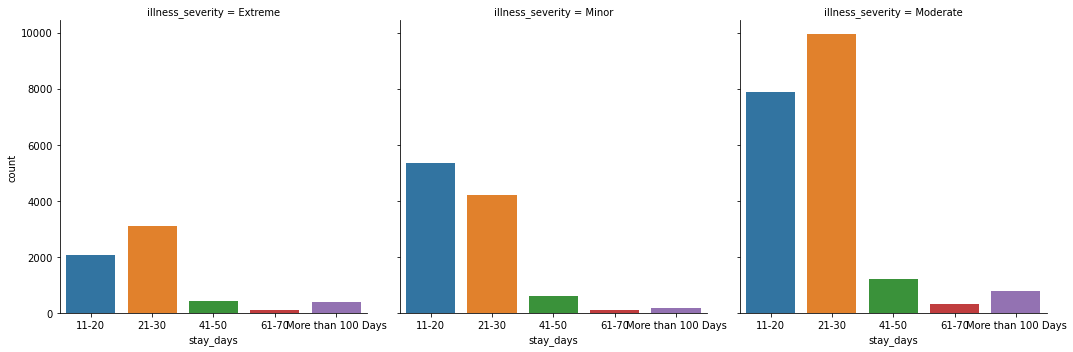

In [28]:
bivariate_analysis(df1, "stay_days", "illness_severity", selected_list)

/Users/jiezhou/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


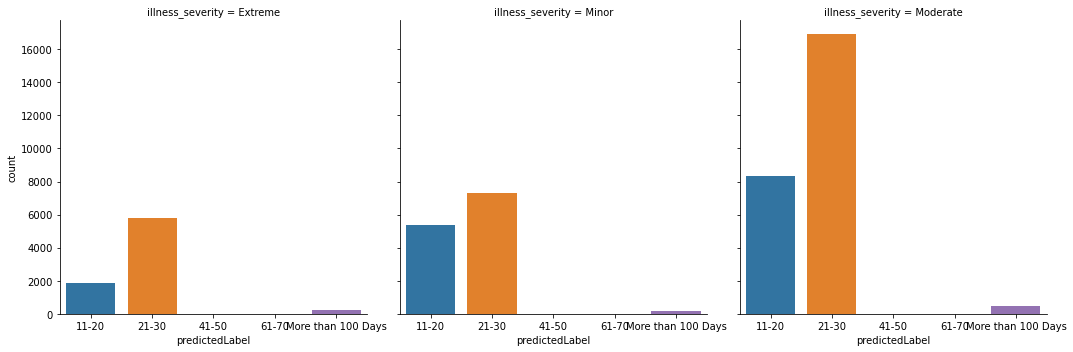

In [29]:
bivariate_analysis(df1, "predictedLabel", "illness_severity", selected_list)